# Problem Description: acosx -> asinx

Governing PDE: $$ G:u(x)=acos(x)↦v(x)=asin(x), \in [-1,1],\quad a\in [1,10]$$

Initial Condition: $$u(0) = a$$
Boundary Condition: $$v(0) = 0$$


In [81]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:0


In [82]:
torch.manual_seed(42)
np.random.seed(42)

N_total   = 100
N_train   = 70
N_test    = N_total - N_train

m_sensors = 30           # branch sensors
N_trunk   = 30           # trunk evaluation points
x_min, x_max = 0.0, 3.0

# sensors locations and trunk locations (can be same grid; kept separate for clarity)
x_sensors = torch.linspace(x_min, x_max, m_sensors, device=device).view(-1, 1)  # (30,1)
x_trunk   = torch.linspace(x_min, x_max, N_trunk,   device=device).view(-1, 1)  # (30,1)

# amplitudes a in [0,10], shape (100,1)
a_values = (10.0 * torch.rand(N_total, 1, device=device)).float()

# branch input u(x)=a cos x observed at sensors -> (100,30)
f_sensors = (a_values * torch.cos(x_sensors.T)).float()   # (100,30)

# target v(x)=a sin x on trunk grid -> (100,30)
u_true = (a_values * torch.sin(x_trunk.T)).float()        # (100,30)

print("f_sensors:", tuple(f_sensors.shape))
print("u_true   :", tuple(u_true.shape))
print("a_values :", tuple(a_values.shape))
print("x_trunk  :", tuple(x_trunk.shape))

f_sensors: (100, 30)
u_true   : (100, 30)
a_values : (100, 1)
x_trunk  : (30, 1)


In [83]:
f_train, f_test = f_sensors[:N_train], f_sensors[N_train:]
u_train, u_test = u_true[:N_train], u_true[N_train:]
a_train, a_test = a_values[:N_train], a_values[N_train:]

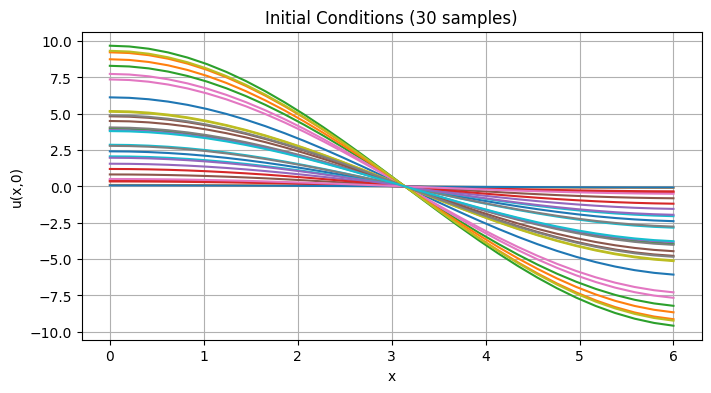

In [84]:
plt.figure(figsize=(8, 4))
for i in range(30):
    plt.plot(x_coords.cpu(), f_sensors[i].cpu())
plt.xlabel("x")
plt.ylabel('u(x,0)')
plt.title("Initial Conditions (30 samples)")
plt.grid(True)
plt.show()

In [ ]:
class PIDeepONet(nn.Module):
    def __init__(self, sensors=30, trunk_dim=1, width=64, p=64):
        super().__init__()
        act = nn.Tanh()
        self.branch = nn.Sequential(
            nn.Linear(sensors, width), act,
            nn.Linear(width, width), act,
            nn.Linear(width, p)
        )
        self.trunk = nn.Sequential(
            nn.Linear(trunk_dim, width), act,
            nn.Linear(width, width), act,
            nn.Linear(width, p)
        )
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, branch_in, trunk_in):
        """
        branch_in: (B, sensors)
        trunk_in : (N, 1) shared points only
        return   : (B, N)
        """
        b = self.branch(branch_in)     # (B,p)
        t = self.trunk(trunk_in)       # (N,p)
        return b @ t.T + self.bias     # (B,N)

model = PIDeepONet(sensors=m_sensors, trunk_dim=1, width=64, p=64).to(device)

dry-run output: (70, 30)


In [ ]:
def pde_loss_shared(model, branch_u_sensors, a_vals):
    """
    PDE: dv/dx - a cos x = 0
    - use shared collocation x_f: (Nf,1), requires_grad=True
    - v(x_f) computed by model(branch, x_f): (B,Nf)
    - dv/dx via autograd w.r.t x_f (shared)
    """
    B = branch_u_sensors.shape[0]

    # shared collocation points
    x_f = torch.rand(1, device=branch_u_sensors.device) * (x_max - x_min) + x_min
    x_f.requires_grad_(True)

    v = model(branch_u_sensors, x_f)           # (B,Nf)
    v_ = v.unsqueeze(-1)                       # (B,Nf,1)

    dv_dx = torch.autograd.grad(
        outputs=v_, inputs=x_f,
        grad_outputs=torch.ones_like(v_),
        create_graph=True, retain_graph=True
    )[0]                                       # (Nf,1)

    # expand dv_dx to (B,Nf,1)
    dv_dx = dv_dx.unsqueeze(0).expand(B, -1, -1)

    # analytic u(x_f) = a cos x_f
    a = a_vals.view(B, 1, 1)
    u_xf = a * torch.cos(x_f).unsqueeze(0)     # (B,Nf,1)

    r = dv_dx - u_xf
    return (r**2).mean()

def bc_loss_v0(model, branch_u_sensors):
    """
    BC: v(0)=0
    """
    x0 = torch.zeros(1, 1, device=branch_u_sensors.device)
    v0 = model(branch_u_sensors, x0)           # (B,1)
    return (v0**2).mean()

def train_step(model, optimizer,
               f_in, x_trunk, v_true, a_vals,
               w_data=1.0, w_pde=1.0, w_bc=1.0):
    model.train()
    optimizer.zero_grad()

    v_pred = model(f_in, x_trunk)              # (B,N)
    loss_data = ((v_pred - v_true)**2).mean()

    loss_pde = pde_loss_shared(model, f_in, a_vals)
    loss_bc  = bc_loss_v0(model, f_in)

    loss = w_data*loss_data + w_pde*loss_pde + w_bc*loss_bc
    loss.backward()
    optimizer.step()

    return float(loss.detach().cpu()), float(loss_data.detach().cpu()), float(loss_pde.detach().cpu()), float(loss_bc.detach().cpu())


In [87]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=800, gamma=0.5)

n_epochs = 3000

for epoch in range(1, n_epochs + 1):
    # (optional) physics warm-up
    w_pde = 0.1 if epoch < 300 else 1.0

    l_tot, l_d, l_p, l_bc = train_step(
        model, optimizer,
        f_train, x_trunk, u_train, a_train,
        w_data=1.0, w_pde=w_pde, w_bc=1.0,
        Nf=128
    )
    scheduler.step()

    if epoch % 200 == 0:
        model.eval()
        with torch.no_grad():
            pred_test = model(f_test, x_trunk)
            test_mse = ((pred_test - u_test)**2).mean().item()
        print(f"[{epoch:4d}] loss={l_tot:.3e} data={l_d:.3e} pde={l_p:.3e} bc={l_bc:.3e} | test_mse={test_mse:.3e}")

[ 200] loss=6.862e+00 data=4.313e+00 pde=5.721e+00 bc=1.976e+00 | test_mse=5.355e+00
[ 400] loss=1.173e+01 data=5.134e+00 pde=3.907e+00 bc=2.686e+00 | test_mse=6.682e+00
[ 600] loss=1.087e+01 data=4.763e+00 pde=3.728e+00 bc=2.383e+00 | test_mse=6.066e+00
[ 800] loss=1.136e+01 data=4.565e+00 pde=4.514e+00 bc=2.281e+00 | test_mse=5.727e+00
[1000] loss=9.758e+00 data=4.307e+00 pde=3.506e+00 bc=1.945e+00 | test_mse=5.004e+00
[1200] loss=1.026e+01 data=4.230e+00 pde=4.124e+00 bc=1.905e+00 | test_mse=4.939e+00
[1400] loss=1.059e+01 data=4.316e+00 pde=4.175e+00 bc=2.097e+00 | test_mse=5.266e+00
[1600] loss=9.970e+00 data=4.169e+00 pde=3.910e+00 bc=1.891e+00 | test_mse=4.623e+00
[1800] loss=9.651e+00 data=4.113e+00 pde=3.654e+00 bc=1.885e+00 | test_mse=4.548e+00
[2000] loss=9.958e+00 data=4.062e+00 pde=4.015e+00 bc=1.881e+00 | test_mse=4.463e+00
[2200] loss=9.672e+00 data=4.019e+00 pde=3.757e+00 bc=1.895e+00 | test_mse=4.560e+00
[2400] loss=1.010e+01 data=3.970e+00 pde=4.251e+00 bc=1.881e+00 |

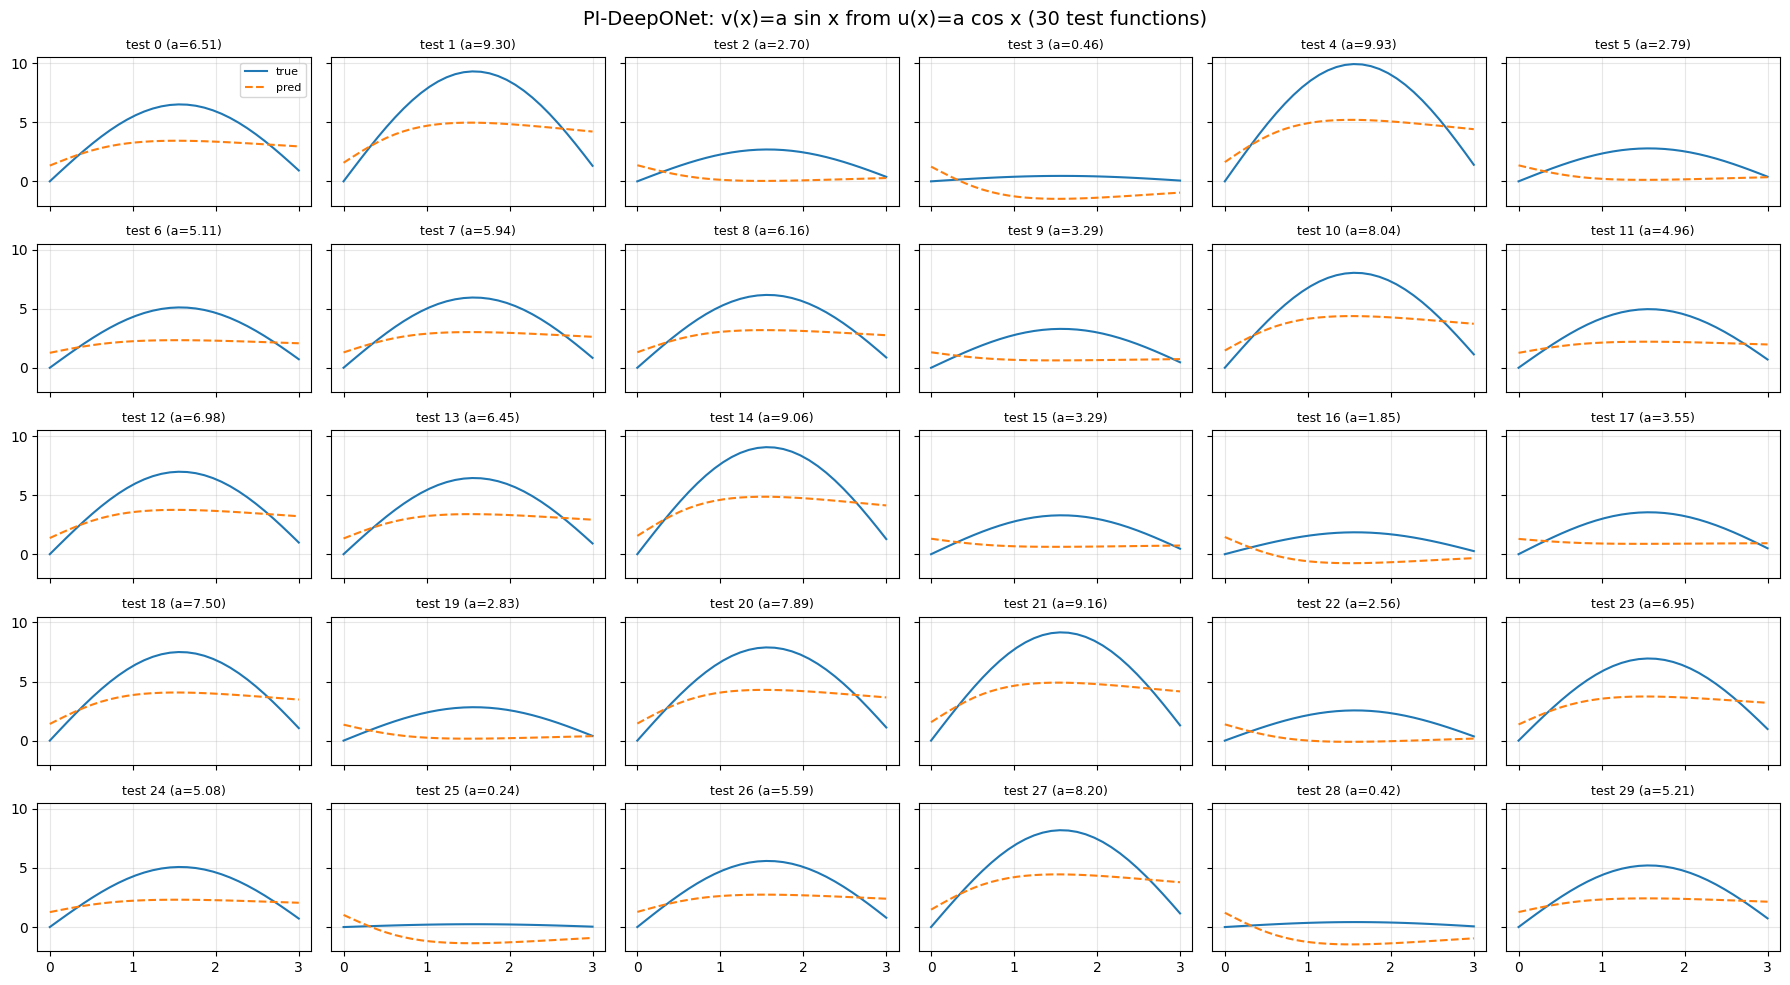

In [88]:
model.eval()
with torch.no_grad():
    u_pred_test = model(f_test, x_trunk).cpu().numpy()   # (30,30)
u_true_test = u_test.cpu().numpy()                       # (30,30)
x_np = x_trunk.cpu().numpy().flatten()
a_np = a_test.cpu().numpy().flatten()

# 5x6 grid to show all 30 tests
fig, axes = plt.subplots(5, 6, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(N_test):
    ax = axes[i]
    ax.plot(x_np, u_true_test[i], label="true")
    ax.plot(x_np, u_pred_test[i], linestyle="--", label="pred")
    ax.set_title(f"test {i} (a={a_np[i]:.2f})", fontsize=9)
    ax.grid(True, alpha=0.3)

# legend once
axes[0].legend(fontsize=8)
plt.suptitle("PI-DeepONet: v(x)=a sin x from u(x)=a cos x (30 test functions)", fontsize=14)
plt.tight_layout()
plt.show()